# fct_monthly_schedule_route_direction_summary
* schedule stats (headway, freq, n_trips) by route-direction
* operator summary charts
* [Tiffany's explanation](https://github.com/cal-itp/data-analyses/issues/1752#issuecomment-3563818122)

In [1]:
import datetime
import sys

import _sql_query
import google.auth
import pandas as pd
from google.cloud import bigquery
from loguru import logger
from shared_utils import rt_dates
from update_vars import SEGMENT_GCS

credentials, project = google.auth.default()

# import _operator_grain_route_dir_visuals as _report_operator_visuals
from IPython.display import HTML, Image, Markdown, display, display_html
from omegaconf import OmegaConf
from shared_utils import gtfs_utils_v2, portfolio_utils, publish_utils
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS

readable_dict = OmegaConf.load("new_readable.yml")
import _portfolio_charts
import altair as alt

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# rt_dates.DATES

In [4]:
aug_2025 = "2025-08-20"

In [5]:
analysis_name = "City and County of San Francisco"

In [6]:
def formatted(number):
    return "{:,}".format(number)

In [7]:
df = _sql_query.download_with_pandas_gbq(
    project="cal-itp-data-infra-staging",
    filename="tiffany_mart_gtfs_rollup.fct_monthly_schedule_rt_route_direction_summary",
)


        SELECT 
            *
        FROM `cal-itp-data-infra-staging`.`tiffany_mart_gtfs_rollup`.`fct_monthly_schedule_rt_route_direction_summary`
        WHERE month_first_day >=  DATE('2025-01-01')
    


/opt/conda/lib/python3.11/site-packages/pandas_gbq/gbq.py:38: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa


Downloading: 100%|██████████|
download time: 0:00:09.808923


In [8]:
def prep_route_direction() -> pd.DataFrame:
    df = _sql_query.download_with_pandas_gbq(
        project="cal-itp-data-infra-staging",
        filename="tiffany_mart_gtfs_rollup.fct_monthly_schedule_rt_route_direction_summary",
    )

    df2 = df[
        [
            "month_first_day",
            "name",
            "route_name",
            "direction_id",
            "frequency_all_day",
            "frequency_offpeak",
            "frequency_peak",
            "daily_service_hours",
            "daily_trips_peak",
            "daily_trips_offpeak",
            "daily_trips_all_day",
            "day_type",
        ]
    ]
    # Temporarily add analysis_name
    df2 = df2.pipe(portfolio_utils.standardize_portfolio_organization_names)
    df2 = df2.drop_duplicates()
    df2.columns = df2.columns.str.replace("_", " ").str.title()
    df2["Month First Day"] = pd.to_datetime(df2["Month First Day"]).dt.strftime("%B %Y")
    df2 = df2.rename(
        columns={
            "Direction Id": "Direction",
            "Month First Day": "Date",
            "Route Name": "Route",
        }
    )
    # Add some new columns
    df2["Daily Service Minutes"] = df2["Daily Service Hours"] * 60
    df2["Average Scheduled Minutes"] = (
        df2["Daily Service Minutes"] / df2["Daily Trips All Day"]
    )
    df2["Average Scheduled Minutes"].describe()
    df2["Headway All Day"] = 60 / df2["Frequency All Day"]
    df2["Headway Peak"] = 60 / df2["Frequency Peak"]
    df2["Headway Offpeak"] = 60 / df2["Frequency Offpeak"]

    return df2

In [9]:
route_direction = prep_route_direction()


        SELECT 
            *
        FROM `cal-itp-data-infra-staging`.`tiffany_mart_gtfs_rollup`.`fct_monthly_schedule_rt_route_direction_summary`
        WHERE month_first_day >=  DATE('2025-01-01')
    
Downloading: 100%|██████████|
download time: 0:00:09.159501


In [10]:
subset_df = route_direction.loc[route_direction["Analysis Name"].isin([analysis_name])]

In [11]:
subset_df.shape

(371, 19)

In [12]:
subset_df.head(2)

,Date,Name,Route,Direction,Frequency All Day,Frequency Offpeak,Frequency Peak,Daily Service Hours,Daily Trips Peak,Daily Trips Offpeak,Daily Trips All Day,Day Type,Analysis Name,Source Record Id,Daily Service Minutes,Average Scheduled Minutes,Headway All Day,Headway Peak,Headway Offpeak
910,October 2025,Bay Area 511 Muni Schedule,FBUS__FBUS MARKET & WHARVES BUS,0,0.25,NaN,NaN,0.53,NaN,NaN,1.00,Saturday,City and County of San Francisco,recHD22phgJs34JHP,32.00,32.00,240.00,NaN,NaN
911,October 2025,Bay Area 511 Muni Schedule,FBUS__FBUS MARKET & WHARVES BUS,0,0.25,NaN,NaN,0.53,NaN,NaN,1.00,Sunday,City and County of San Francisco,recHD22phgJs34JHP,32.00,32.00,240.00,NaN,NaN


### Operator Grain: Scheduled Minutes

In [15]:
def create_route_dropdown(df: pd.DataFrame):
    routes_list = df["Route"].unique().tolist()
    route_dropdown = alt.binding_select(
        options=routes_list,
        name="Routes: ",
    )

    # Column that controls the bar charts
    xcol_param = alt.selection_point(
        fields=["Route"], value=routes_list[0], bind=route_dropdown
    )
    return xcol_param

In [27]:
readable_dict.avg_scheduled_minutes.tooltip

['Date', 'Route', 'Direction', 'Average Scheduled Minutes']

In [ ]:
tooltip

In [24]:
def create_scheduled_minutes(df: pd.DataFrame):
    chart_dict = readable_dict.avg_scheduled_minutes

    xcol_param = create_route_dropdown(df)

    dir_0_chart = _portfolio_charts.bar_chart(
        df=df.loc[df.Direction == 0],
        x_col="Date",
        y_col="Average Scheduled Minutes",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=chart_dict.tooltip,
        date_format="",
        y_ticks=chart_dict.ticks,
    )

    dir_0_chart = (
        _portfolio_charts.configure_chart(
            dir_0_chart,
            width=200,
            height=250,
            title=f"{chart_dict.title} for Direction 0",
            subtitle=chart_dict.subtitle,
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )

    dir_1_chart = _portfolio_charts.bar_chart(
        df=subset_df.loc[subset_df.Direction == 1],
        x_col="Date",
        y_col="Average Scheduled Minutes",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=chart_dict.tooltip,
        date_format="",
        y_ticks=chart_dict.ticks,
    )
    dir_1_chart = (
        _portfolio_charts.configure_chart(
            dir_1_chart,
            width=200,
            height=250,
            title="Direction 1",
            subtitle="",
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )
    chart = alt.hconcat(dir_0_chart, dir_1_chart)
    return chart

In [25]:
create_scheduled_minutes(subset_df)

SchemaValidationError: Multiple errors were found.

Error 1: '['Date', 'Route', 'Direction', 'Average Scheduled Minutes']' is an invalid value for `field`. Valid values are of type 'string' or 'object'.

Error 2: '['Date', 'Route', 'Direction', 'Average Scheduled Minutes']' is an invalid value for `field`. Valid values are of type 'string' or 'object'.

alt.HConcatChart(...)

### Operator: Total Scheduled Trips for Vehicles Going Direction X
* Use `daily_trips_all_day`

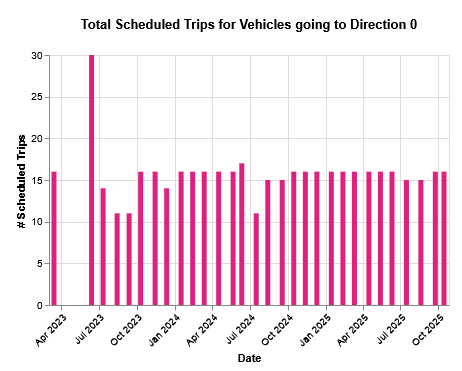

In [ ]:
n_scheduled_dict = readable_dict.n_scheduled_graph

In [ ]:
n_scheduled_tooltip = [
    "Date",
    "Route",
    "Direction",
    "Daily Trips All Day",
]

In [ ]:
n_scheduled_title = "Total Scheduled Trips"

In [ ]:
df2["Daily Trips All Day"].describe()

In [ ]:
df2.loc[df2["Daily Trips All Day"] == 4550]

In [ ]:
subset_df["Daily Trips All Day"].describe()

In [ ]:
subset_df.loc[subset_df["Daily Trips All Day"] > 100].describe()

In [ ]:
dir_0_scheduled_chart = bar_chart(
    df=subset_df.loc[subset_df.Direction == 0],
    x_col="Date",
    y_col="Daily Trips All Day",
    color_col="Direction",
    color_scheme=[*n_scheduled_dict.colors],
    tooltip_cols=n_scheduled_tooltip,
    date_format="",
    y_ticks=[i for i in range(0, int(200) + 50, 50)],
)

In [ ]:
dir_1_scheduled_chart = bar_chart(
    df=subset_df.loc[subset_df.Direction == 1],
    x_col="Date",
    y_col="Daily Trips All Day",
    color_col="Direction",
    color_scheme=[*n_scheduled_dict.colors],
    tooltip_cols=n_scheduled_tooltip,
    date_format="",
    y_ticks=[i for i in range(0, int(200) + 50, 50)],
)

In [ ]:
dir_0_scheduled_chart = (
    _report_operator_visuals.configure_chart(
        dir_0_scheduled_chart,
        width=200,
        height=250,
        title=f"{n_scheduled_title} for Direction 0",
        subtitle="",
    )
    .add_params(xcol_param)
    .transform_filter(xcol_param)
)

In [ ]:
dir_1_scheduled_chart = (
    _report_operator_visuals.configure_chart(
        dir_1_scheduled_chart,
        width=200,
        height=250,
        title="Direction 1",
        subtitle="",
    )
    .add_params(xcol_param)
    .transform_filter(xcol_param)
)

In [ ]:
alt.hconcat(dir_0_scheduled_chart, dir_1_scheduled_chart)

### Frequency of Trips Peak/Off Peak for Direction X
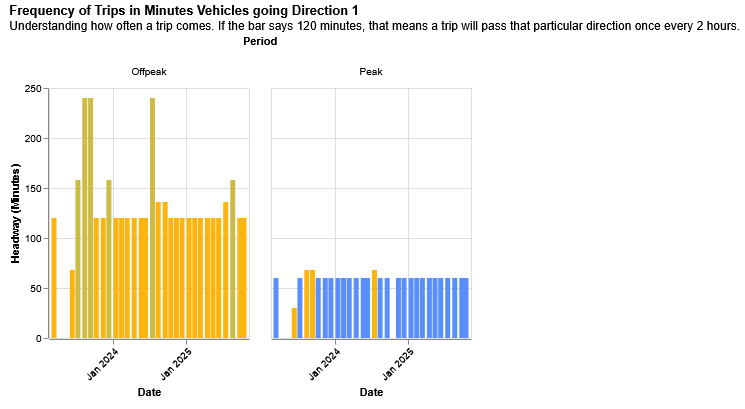

In [ ]:
frequency_dict = readable_dict.frequency_graph

In [ ]:
subset_df.columns

In [ ]:
subset_df["Headway All Day"].describe()

In [ ]:
subset_df.sample()

In [ ]:
[i for i in range(0, int(240) + 30, 30)]

In [ ]:
freq_dir_0 = bar_chart(
    df=subset_df.loc[subset_df.Direction == 0],
    x_col="Date",
    y_col="Headway All Day",
    color_col="Direction",
    color_scheme=[*frequency_dict.colors],
    tooltip_cols=[
        "Date",
        "Route",
        "Direction",
        "Headway All Day",
    ],
    date_format="",
    y_ticks=[i for i in range(0, int(240) + 30, 30)],
)

In [ ]:
freq_dir_0 = (
    _report_operator_visuals.configure_chart(
        freq_dir_0,
        width=200,
        height=250,
        title=f"{frequency_dict.title} for Direction 0",
        subtitle=frequency_dict.subtitle,
    )
    .add_params(xcol_param)
    .transform_filter(xcol_param)
)

In [ ]:
freq_dir_1 = bar_chart(
    df=subset_df.loc[subset_df.Direction == 1],
    x_col="Date",
    y_col="Headway All Day",
    color_col="Direction",
    color_scheme=[*frequency_dict.colors],
    tooltip_cols=[
        "Date",
        "Route",
        "Direction",
        "Headway All Day",
    ],
    date_format="",
    y_ticks=[i for i in range(0, int(240) + 30, 30)],
)

In [ ]:
freq_dir_1 = (
    _report_operator_visuals.configure_chart(
        freq_dir_1,
        width=200,
        height=250,
        title=f"Direction 1",
        subtitle="",
    )
    .add_params(xcol_param)
    .transform_filter(xcol_param)
)

In [ ]:
alt.hconcat(freq_dir_0, freq_dir_1)

### Text Table

In [ ]:
def create_text_table(df: pd.DataFrame) -> pd.DataFrame:
    most_recent_date = df["Date"].max()
    most_recent_df = df.loc[df.Date == most_recent_date]
    text_table_df = most_recent_df.melt(
        id_vars=[
            "Date",
            "Route",
            "Direction",
        ],
        value_vars=[
            "Average Scheduled Minutes",
            "Average Scheduled Minutes",
            "Daily Trips All Day",
            "Headway All Day",
            "Headway Peak",
            "Headway Offpeak",
        ],
    ).sort_values(by=["Route", "Direction"])

    text_table_df.value = text_table_df.value.fillna(0)
    text_table_df.value = text_table_df.value.astype(int)
    text_table_df.value = text_table_df.value.astype(str)
    text_table_df.value = text_table_df.value.replace("0", "N/A")

    text_table_df["Zero"] = 0

    text_table_df["combo_col"] = (
        text_table_df.variable.astype(str) + ": " + text_table_df.value.astype(str)
    )
    text_table_df["Direction"] = text_table_df.Direction.astype(str)

    return text_table_df

In [ ]:
options = ["0", "1"]

In [ ]:
input_dropdown = alt.binding_radio(
    # Add the empty selection which shows all when clicked
    options=options,
    labels=options,
    name="Direction: ",
)

In [ ]:
selection = alt.selection_point(
    fields=["Direction"],
    value=options[0],
    bind=input_dropdown,
)

In [ ]:
selection

In [ ]:
def text_chart(df:pd.DataFrame):
    chart = (alt.Chart(df)
            .mark_text()
            .encode(x=alt.X(f")))

In [ ]:
def text_table(df: pd.DataFrame) -> alt.Chart:

    # Create the chart
    text_chart = (
        alt.Chart(df)
        .mark_text()
        .encode(x=alt.X("Zero:Q", axis=None), y=alt.Y("combo_col", axis=None))
    )

    text_chart = text_chart.encode(text="combo_col:N")

    return text_chart

In [ ]:
(
    _report_operator_visuals.configure_chart(
        text_chart,
        width=400,
        height=250,
        title="Route Statistics",
        subtitle="Use the menus to filter for directions and routes.",
    )
).transform_filter(xcol_param).add_params(selection).transform_filter(selection)